In [22]:
import glob
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pickle

from qiskit import *
from qiskit.quantum_info import Statevector

import dqva

from utils.graph_funcs import *
from utils.helper_funcs import *

from ansatz import qaoa, qv_ansatz, dqv_ansatz, dqv_cut_ansatz

In [2]:
test_graphs = glob.glob('benchmark_graphs/N6_p20_graphs/*')
test_graphs = sorted(test_graphs, key=lambda g: int(g.split('/')[-1].strip('G.txt')))
print(len(test_graphs))

50


benchmark_graphs/N6_p20_graphs/G2.txt
Optimal: ('000111', 3)


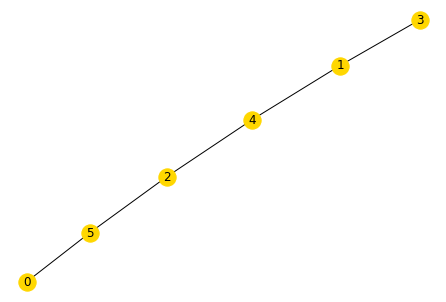

In [3]:
graph = test_graphs[1]
print(graph)
G = graph_from_file(graph)
print('Optimal:', brute_force_search(G))
nx.draw_spring(G, with_labels=True, node_color='gold')

In [5]:
sample_graphs = test_graphs[0:10]
print(len(sample_graphs))
print(sample_graphs)

10
['benchmark_graphs/N6_p20_graphs/G1.txt', 'benchmark_graphs/N6_p20_graphs/G2.txt', 'benchmark_graphs/N6_p20_graphs/G3.txt', 'benchmark_graphs/N6_p20_graphs/G4.txt', 'benchmark_graphs/N6_p20_graphs/G5.txt', 'benchmark_graphs/N6_p20_graphs/G6.txt', 'benchmark_graphs/N6_p20_graphs/G7.txt', 'benchmark_graphs/N6_p20_graphs/G8.txt', 'benchmark_graphs/N6_p20_graphs/G9.txt', 'benchmark_graphs/N6_p20_graphs/G10.txt']


In [7]:
qaoa_data = {}
dqva_data = {}

for graph_name in sample_graphs:
    print(graph_name)
    G = graph_from_file(graph_name)
    nq = len(G.nodes())
    opt_mis = brute_force_search(G)[1]
    
    init_state = '0'*nq
    mixer_order = list(range(nq))
    
    graph_key = graph_name.split('/')[-1].strip('.txt')
    graph_qaoa_data = []
    graph_dqva_data = []
    
    print('\n\nBEGIN QAOA\n\n')
    
    for P in [1,2,3]:
        output = dqva.solve_mis_qaoa(init_state, G, P=P, mixer_order=mixer_order, sim='qasm')
        ap_ratio = hamming_weight(output[0]) / opt_mis
        mixer_count = nq * P
        print('-'*30)
        print('Found approximation ratio = {}, with {} partial_mixers'.format(ap_ratio, mixer_count))
        print('-'*30)
        graph_qaoa_data.append((mixer_count, ap_ratio))
    
    qaoa_data[graph_key] = graph_qaoa_data
    
    print('\n\nBEGIN DQVA\n\n')

    for plim in [2, 4, 6]:
        output = dqva.solve_mis_dqva(init_state, G, m=5, mixer_order=mixer_order, sim='qasm', param_lim=plim)
        ap_ratio = hamming_weight(output[0]) / opt_mis
        mixer_count = plim - 1
        print('-'*30)
        print('Found approximation ratio = {}, with {} partial_mixers'.format(ap_ratio, mixer_count))
        print('-'*30)
        graph_dqva_data.append((mixer_count, ap_ratio))
        
    dqva_data[graph_key] = graph_dqva_data

benchmark_graphs/N6_p20_graphs/G1.txt


BEGIN QAOA


Start round 1.1, Initial state = 000000
	Num params = 2
	Current Mixer Order: [0, 1, 2, 3, 4, 5]
	Optimal cost: -2.0
	Found new independent set: 001001, Hamming weight = 2
Start round 1.2, Initial state = 001001
	Num params = 2
	Current Mixer Order: [0, 1, 2, 3, 4, 5]
	Optimal cost: -2.999755859375
	Found new independent set: 110100, Hamming weight = 3
Start round 1.3, Initial state = 110100
	Num params = 2
	Current Mixer Order: [0, 1, 2, 3, 4, 5]
	Optimal cost: -3.0
	None of the measured bitstrings had higher Hamming weight than: 110100
	RETURNING, best hamming weight: 3
------------------------------
Found approximation ratio = 1.0, with 6 partial_mixers
------------------------------
Start round 1.1, Initial state = 000000
	Num params = 4
	Current Mixer Order: [0, 1, 2, 3, 4, 5]
	Optimal cost: -2.0
	Found new independent set: 001001, Hamming weight = 2
Start round 1.2, Initial state = 001001
	Num params = 4
	Current Mixer Order: [

In [8]:
print(qaoa_data)
print(dqva_data)

{'G1': [(6, 1.0), (12, 1.0), (18, 1.0)], 'G2': [(6, 1.0), (12, 1.0), (18, 1.0)], 'G3': [(6, 1.0), (12, 1.0), (18, 1.0)], 'G4': [(6, 1.0), (12, 1.0), (18, 1.0)], 'G5': [(6, 1.0), (12, 1.0), (18, 1.0)], 'G6': [(6, 1.0), (12, 1.0), (18, 1.0)], 'G7': [(6, 1.0), (12, 1.0), (18, 1.0)], 'G8': [(6, 1.0), (12, 1.0), (18, 1.0)], 'G9': [(6, 1.0), (12, 1.0), (18, 1.0)], 'G10': [(6, 1.0), (12, 1.0), (18, 1.0)]}
{'G1': [(1, 0.6666666666666666), (3, 0.6666666666666666), (5, 0.6666666666666666)], 'G2': [(1, 1.0), (3, 1.0), (5, 1.0)], 'G3': [(1, 1.0), (3, 1.0), (5, 1.0)], 'G4': [(1, 1.0), (3, 1.0), (5, 1.0)], 'G5': [(1, 1.0), (3, 1.0), (5, 1.0)], 'G6': [(1, 1.0), (3, 1.0), (5, 1.0)], 'G7': [(1, 1.0), (3, 1.0), (5, 1.0)], 'G8': [(1, 0.6666666666666666), (3, 1.0), (5, 1.0)], 'G9': [(1, 1.0), (3, 1.0), (5, 1.0)], 'G10': [(1, 1.0), (3, 1.0), (5, 1.0)]}


In [9]:
def plot_comparison(qaoa_data, dqva_data, savefig=False, show=True):
    assert(list(qaoa_data.keys()) == list(dqva_data.keys()))
    
    for graph in qaoa_data.keys():
        
        fig, ax = plt.subplots(dpi=150)
        
        for dat, label in zip([qaoa_data, dqva_data], ['QAOA', 'DQVA']):
            xvals = [tup[0] for tup in dat[graph]]
            yvals = [tup[1] for tup in dat[graph]]
            print(label)
            print(xvals)
            print(yvals)
        
            ax.plot(xvals, yvals, label=label)
        
        ax.set_title(graph)
        ax.legend()
        ax.set_ylabel('Approximation Ratio')
        ax.set_xlabel('Number of partial mixers')
        
        if show:
            plt.show()
        plt.close()

QAOA
[6, 12, 18]
[1.0, 1.0, 1.0]
DQVA
[1, 3, 5]
[0.6666666666666666, 0.6666666666666666, 0.6666666666666666]


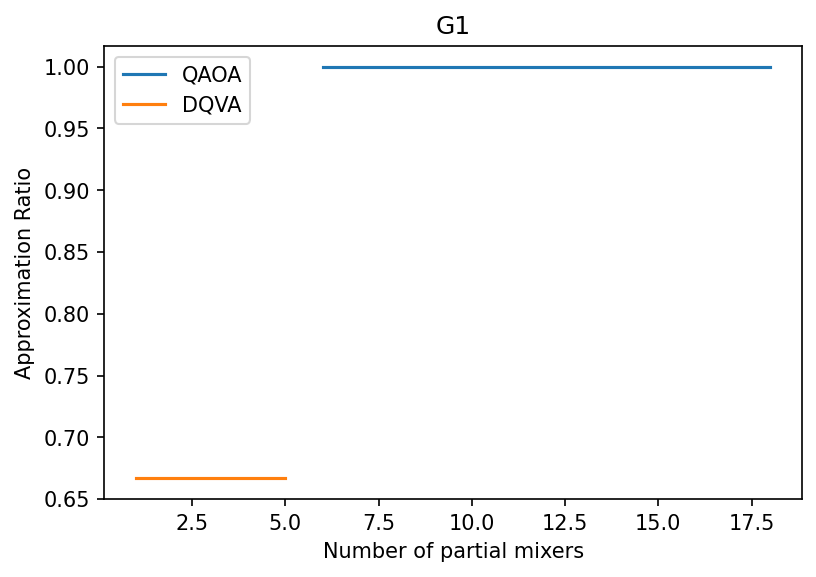

QAOA
[6, 12, 18]
[1.0, 1.0, 1.0]
DQVA
[1, 3, 5]
[1.0, 1.0, 1.0]


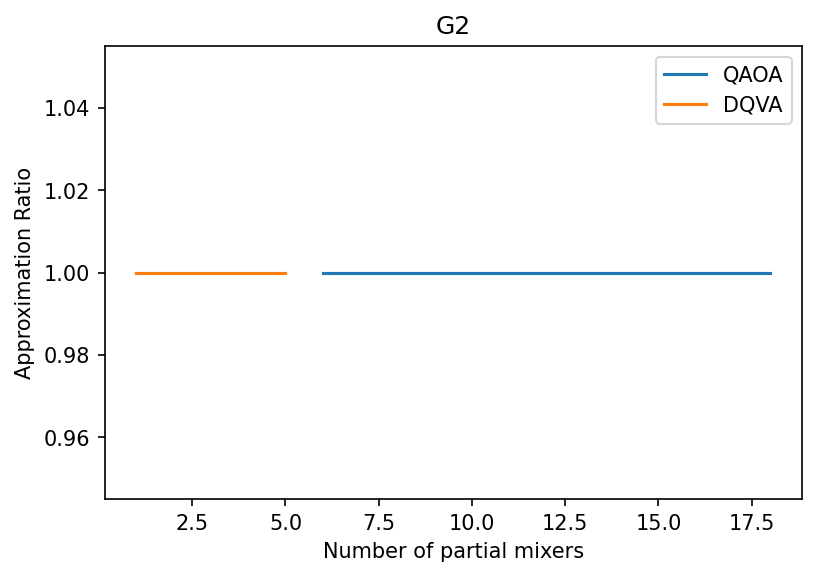

QAOA
[6, 12, 18]
[1.0, 1.0, 1.0]
DQVA
[1, 3, 5]
[1.0, 1.0, 1.0]


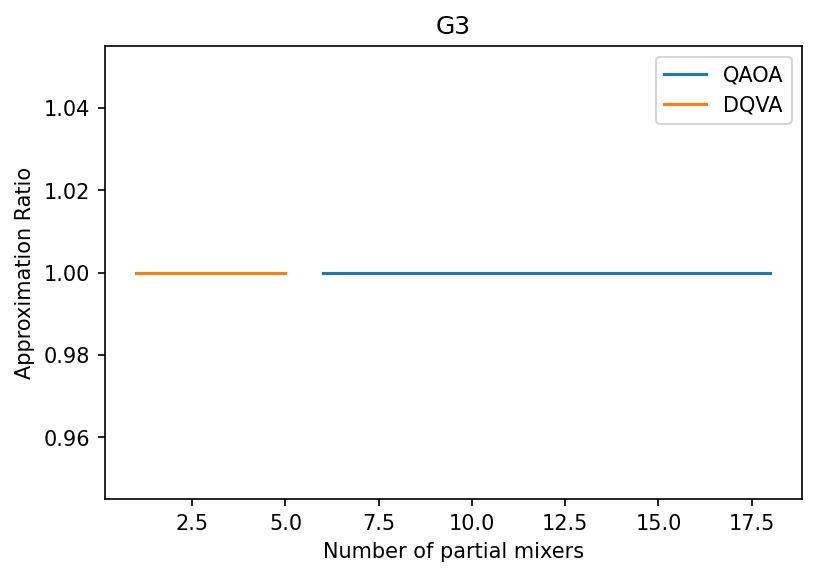

QAOA
[6, 12, 18]
[1.0, 1.0, 1.0]
DQVA
[1, 3, 5]
[1.0, 1.0, 1.0]


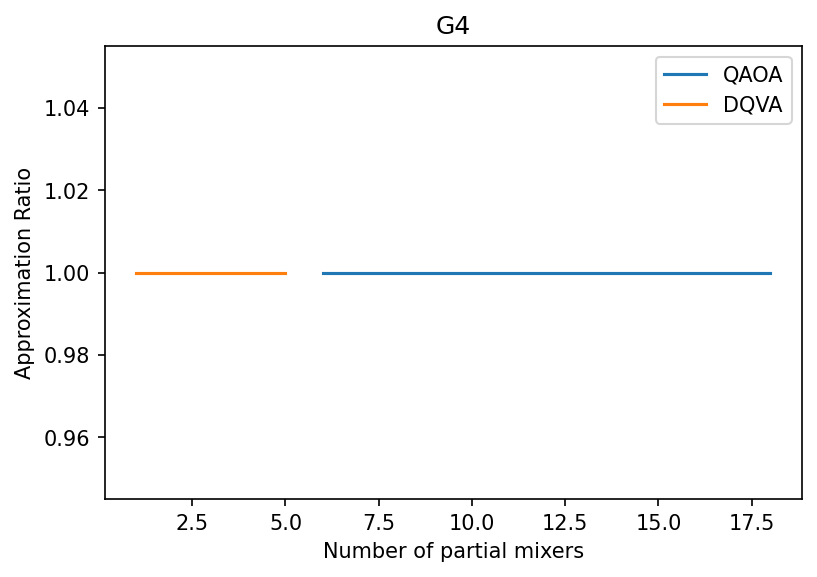

QAOA
[6, 12, 18]
[1.0, 1.0, 1.0]
DQVA
[1, 3, 5]
[1.0, 1.0, 1.0]


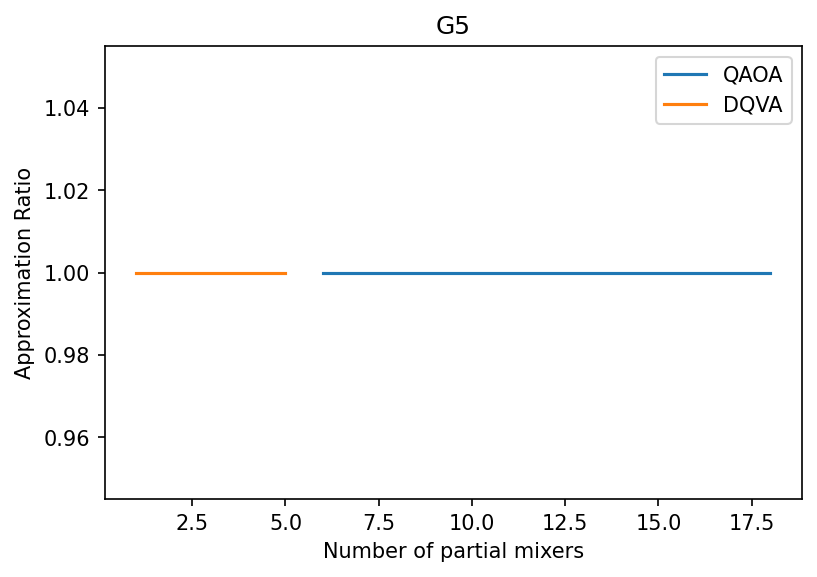

QAOA
[6, 12, 18]
[1.0, 1.0, 1.0]
DQVA
[1, 3, 5]
[1.0, 1.0, 1.0]


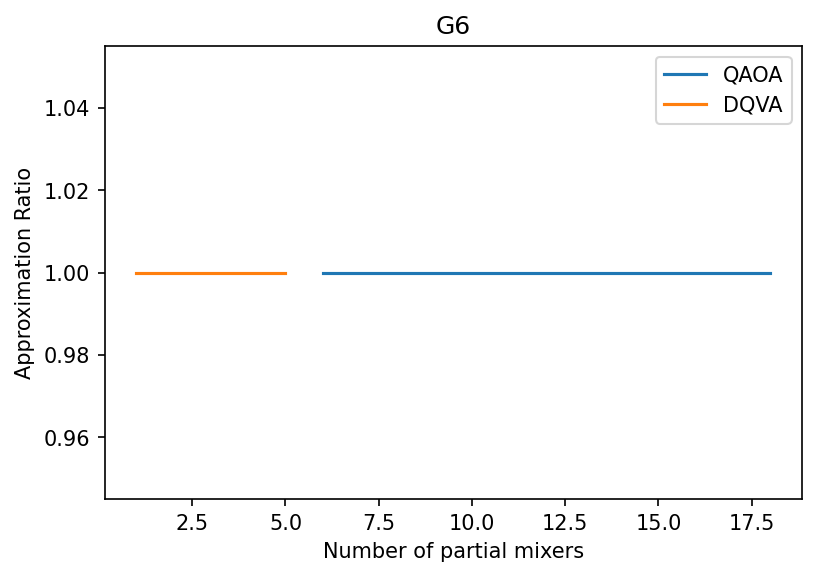

QAOA
[6, 12, 18]
[1.0, 1.0, 1.0]
DQVA
[1, 3, 5]
[1.0, 1.0, 1.0]


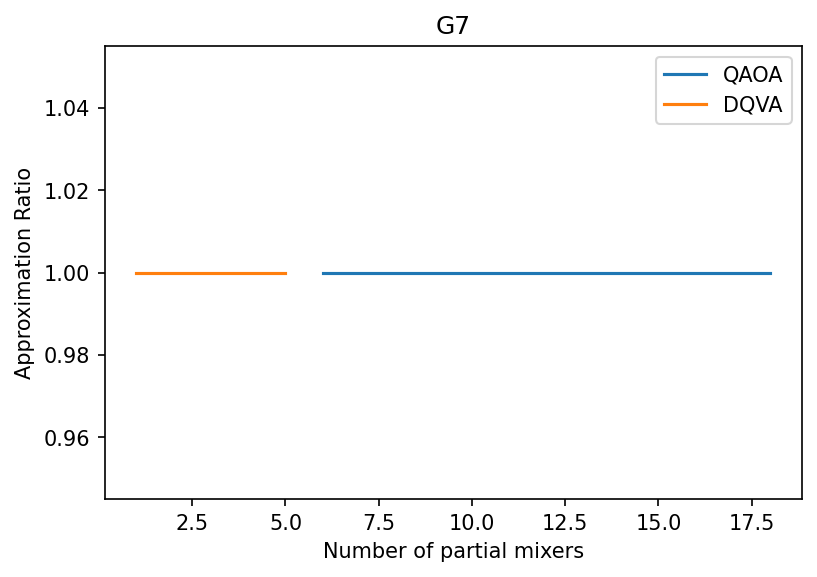

QAOA
[6, 12, 18]
[1.0, 1.0, 1.0]
DQVA
[1, 3, 5]
[0.6666666666666666, 1.0, 1.0]


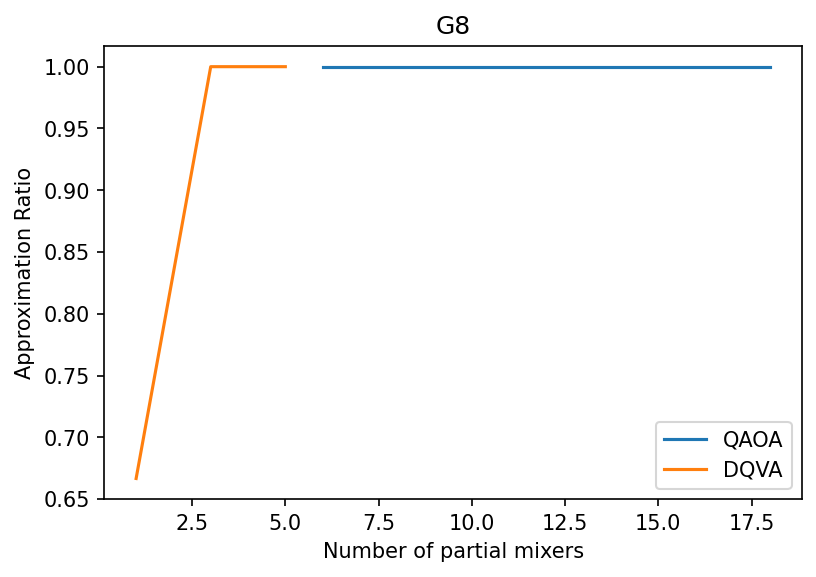

QAOA
[6, 12, 18]
[1.0, 1.0, 1.0]
DQVA
[1, 3, 5]
[1.0, 1.0, 1.0]


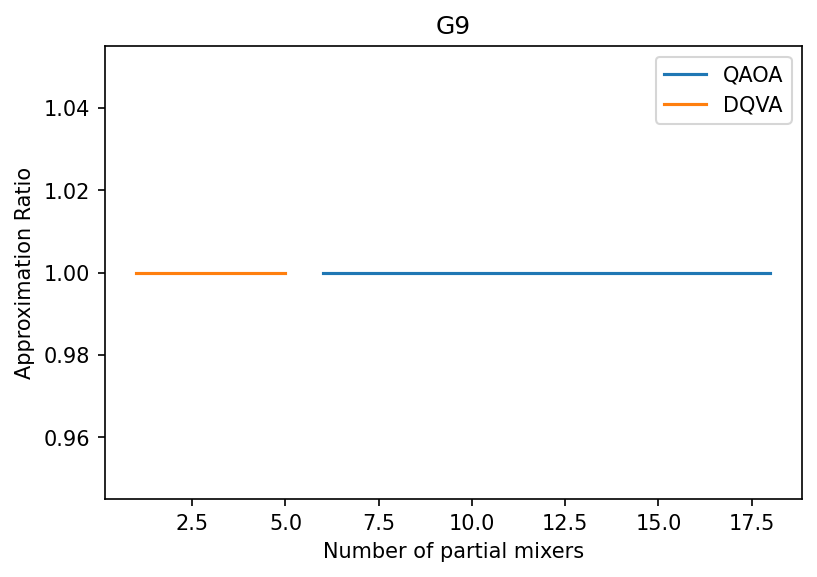

QAOA
[6, 12, 18]
[1.0, 1.0, 1.0]
DQVA
[1, 3, 5]
[1.0, 1.0, 1.0]


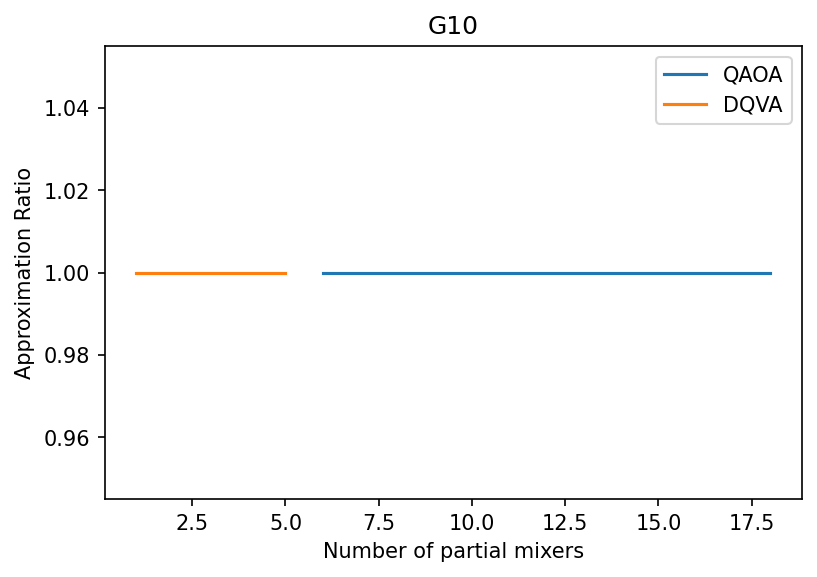

In [10]:
plot_comparison(qaoa_data, dqva_data)

In [11]:
all_x = []
all_y = []
for key, data in qaoa_data.items():
    all_x.append([v[0] for v in data])
    all_y.append([v[1] for v in data])
all_x = np.mean(all_x, axis=0)
all_y = np.mean(all_y, axis=0)
avg_qaoa_data = {'Avg Erdos-Renyi N=12':list(zip(all_x, all_y))}

all_x = []
all_y = []
for key, data in dqva_data.items():
    all_x.append([v[0] for v in data])
    all_y.append([v[1] for v in data])
all_x = np.mean(all_x, axis=0)
all_y = np.mean(all_y, axis=0)
avg_dqva_data = {'Avg Erdos-Renyi N=12':list(zip(all_x, all_y))}

print(avg_qaoa_data)
print(avg_dqva_data)

{'Avg Erdos-Renyi N=12': [(6.0, 1.0), (12.0, 1.0), (18.0, 1.0)]}
{'Avg Erdos-Renyi N=12': [(1.0, 0.9333333333333332), (3.0, 0.9666666666666666), (5.0, 0.9666666666666666)]}


QAOA
[6.0, 12.0, 18.0]
[1.0, 1.0, 1.0]
DQVA
[1.0, 3.0, 5.0]
[0.9333333333333332, 0.9666666666666666, 0.9666666666666666]


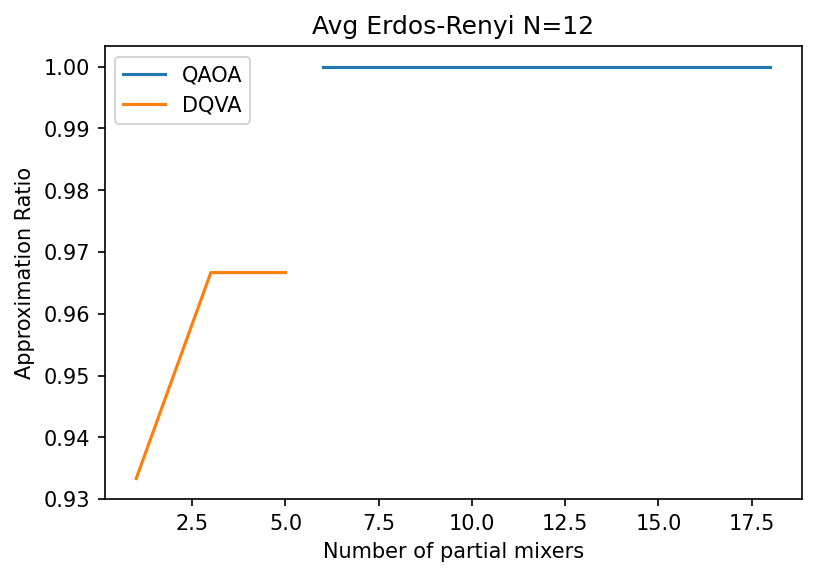

In [12]:
plot_comparison(avg_qaoa_data, avg_dqva_data)

## Load and plot benchmarks

In [155]:
def load_data(graph_fn):
    
    # Load the dqva data
    dqva_y_data = []
    
    graphs = glob.glob('benchmark_results/dqva_P1_qasm/'+graph_fn+'/*')
    lims = [int(fn.split('_')[-3].strip('lim')) for fn in glob.glob(graphs[0]+'/*')]
    lims = list(sorted(set(lims)))
    print('dqva lims:', lims)
    
    for graph_dir in graphs:        
        # get the optimal MIS
        with open(glob.glob(graph_dir+'/*{}*rep1.pickle'.format(lims[0]))[0], 'rb') as pklfile:
            output = pickle.load(pklfile)
        graph_name = '/'.join(output['graph'].split('/')[-3:])
        G = graph_from_file(graph_name)
        nq = len(G.nodes())
        opt_mis = brute_force_search(G)[1]
        
        cur_graph_data = []
        for val in lims:
            reps = glob.glob(graph_dir+'/*{}*rep*.pickle'.format(val))
            cur_val_data = []
            for rep in reps:
                with open(rep, 'rb') as pklfile:
                    output = pickle.load(pklfile)
                    cur_mis = output['out'][0]
                    cur_val_data.append(hamming_weight(cur_mis) / opt_mis)
            cur_graph_data.append(np.mean(cur_val_data))
        dqva_y_data.append(cur_graph_data)
    
    # The averaged results for each graph is stored in the dqva_y_data list
    dqva_xvals = []
    for lim in lims:
        if lim // (nq + 1) <= 1:
            num_phase_sep = 1
        else:
            num_phase_sep = lim // (nq + 1)
        dqva_xvals.append(lim-num_phase_sep)
        
    dqva_data = {'x':dqva_xvals, 'y':dqva_y_data}
    
    
    # Load the qaoa data
    qaoa_y_data = []
    
    algs = glob.glob('benchmark_results/qaoa_P*_qasm')
    algs = sorted(algs, key=lambda a: int(a.split('_')[-2].strip('P')))
    
    pvals = [int(fn.split('_')[-2].strip('P')) for fn in algs]
    pvals = list(sorted(set(pvals)))
    print('qaoa pvals:', pvals)
    
    graphs = [g.split('/')[-1] for g in glob.glob(algs[0]+'/'+graph_fn+'/*')]
    graphs = sorted(graphs, key=lambda g: int(g.strip('G.txt')))
    
    for graph in graphs:        
        with open(glob.glob(algs[0]+'/'+graph_fn+'/'+graph+'/*')[0], 'rb') as pklfile:
            output = pickle.load(pklfile)
        graph_name = '/'.join(output['graph'].split('/')[-3:])
        G = graph_from_file(graph_name)
        nq = len(G.nodes())
        opt_mis = brute_force_search(G)[1]
        
        cur_graph_data = []
        for alg in algs:
            reps = glob.glob(alg+'/'+graph_fn+'/'+graph+'/*')
            cur_alg_data = []
            for rep in reps:
                with open(rep, 'rb') as pklfile:
                    output = pickle.load(pklfile)
                    cur_mis = output['out'][0]
                    cur_alg_data.append(hamming_weight(cur_mis) / opt_mis)
            cur_graph_data.append(np.mean(cur_alg_data))
        qaoa_y_data.append(cur_graph_data)
        
    # The averaged results for each graph is stored in the qaoa_y_data list
    qaoa_xvals = [p*nq for p in pvals]
    qaoa_data = {'x':qaoa_xvals, 'y':qaoa_y_data}
            
    return dqva_data, qaoa_data

N10_p20_graphs
dqva lims: [2, 4, 6, 16]
qaoa pvals: [1, 2, 3]
{'Avg Erdos-Renyi (N=10, p=20%)': [(1, 0.7398285714285714), (3, 0.8664761904761907), (5, 0.936171428571429), (15, 0.9846)]}
{'Avg Erdos-Renyi (N=10, p=20%)': [(10, 0.9101333333333337), (20, 0.9048476190476193), (30, 0.9152285714285715)]}
QAOA
[10, 20, 30]
[0.9101333333333337, 0.9048476190476193, 0.9152285714285715]
DQVA
[1, 3, 5, 15]
[0.7398285714285714, 0.8664761904761907, 0.936171428571429, 0.9846]


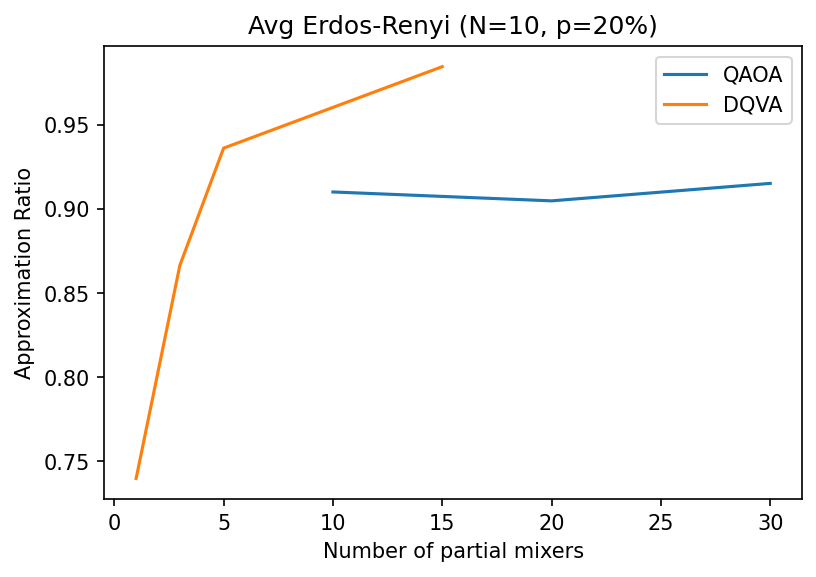

N6_p80_graphs
dqva lims: [16]
qaoa pvals: [1, 2, 3]
{'Avg Erdos-Renyi (N=6, p=80%)': [(14, 0.9986666666666667)]}
{'Avg Erdos-Renyi (N=6, p=80%)': [(6, 0.9619999999999999), (12, 0.9786666666666668), (18, 0.9840000000000001)]}
QAOA
[6, 12, 18]
[0.9619999999999999, 0.9786666666666668, 0.9840000000000001]
DQVA
[14]
[0.9986666666666667]


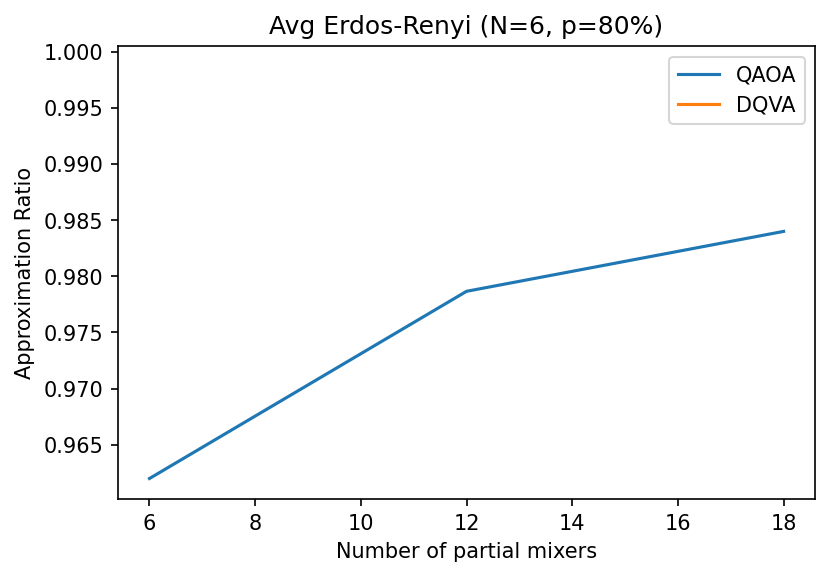

N12_p80_graphs
dqva lims: [16]
qaoa pvals: [1, 2, 3]
{'Avg Erdos-Renyi (N=12, p=80%)': [(15, 0.9406666666666668)]}
{'Avg Erdos-Renyi (N=12, p=80%)': [(12, 0.8663333333333334), (24, 0.8646666666666667), (36, 0.8933333333333333)]}
QAOA
[12, 24, 36]
[0.8663333333333334, 0.8646666666666667, 0.8933333333333333]
DQVA
[15]
[0.9406666666666668]


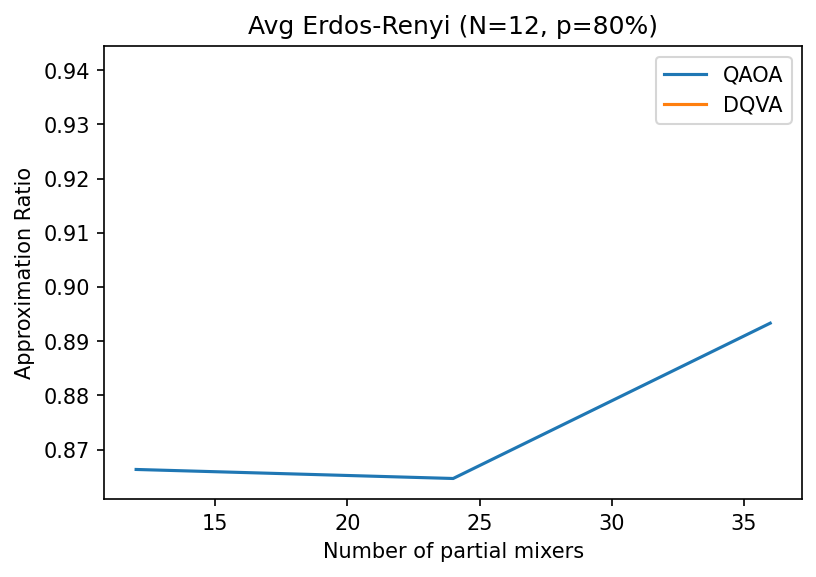

N14_p50_graphs
dqva lims: [2, 4, 6, 16]


/Users/teague/anaconda3/envs/cutEnv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/teague/anaconda3/envs/cutEnv/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


qaoa pvals: [1, 2, 3]
{'Avg Erdos-Renyi (N=14, p=50%)': [(1, 0.6286647058823528), (3, 0.7615813725490197), (5, 0.8683023809523814), (15, nan)]}
{'Avg Erdos-Renyi (N=14, p=50%)': [(14, 0.8704666666666669), (28, 0.8606), (42, nan)]}
QAOA
[14, 28, 42]
[0.8704666666666669, 0.8606, nan]
DQVA
[1, 3, 5, 15]
[0.6286647058823528, 0.7615813725490197, 0.8683023809523814, nan]


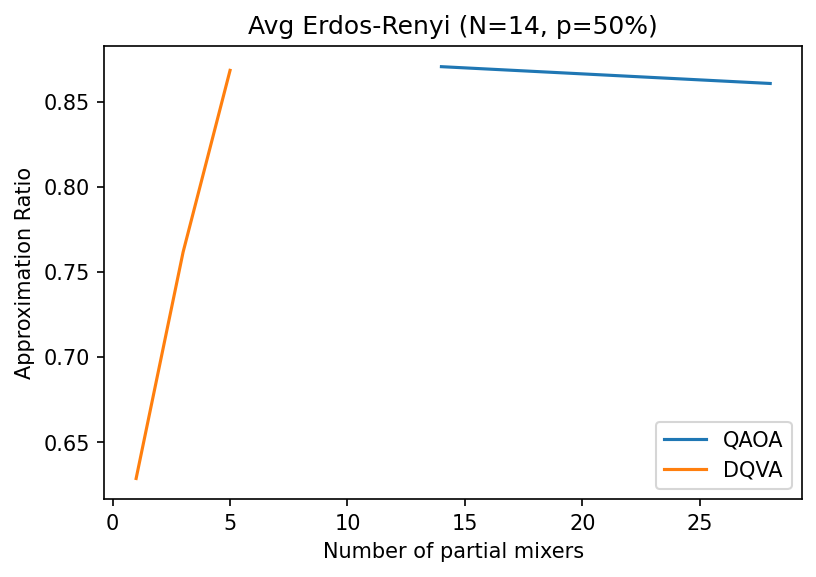

N10_p30_graphs
dqva lims: [2, 4, 6, 16]
qaoa pvals: [1, 2, 3]
{'Avg Erdos-Renyi (N=10, p=30%)': [(1, 0.7234000000000003), (3, 0.8590166666666668), (5, 0.9242999999999999), (15, 0.9797333333333333)]}
{'Avg Erdos-Renyi (N=10, p=30%)': [(10, 0.8860666666666671), (20, 0.8821333333333337), (30, 0.9092000000000005)]}
QAOA
[10, 20, 30]
[0.8860666666666671, 0.8821333333333337, 0.9092000000000005]
DQVA
[1, 3, 5, 15]
[0.7234000000000003, 0.8590166666666668, 0.9242999999999999, 0.9797333333333333]


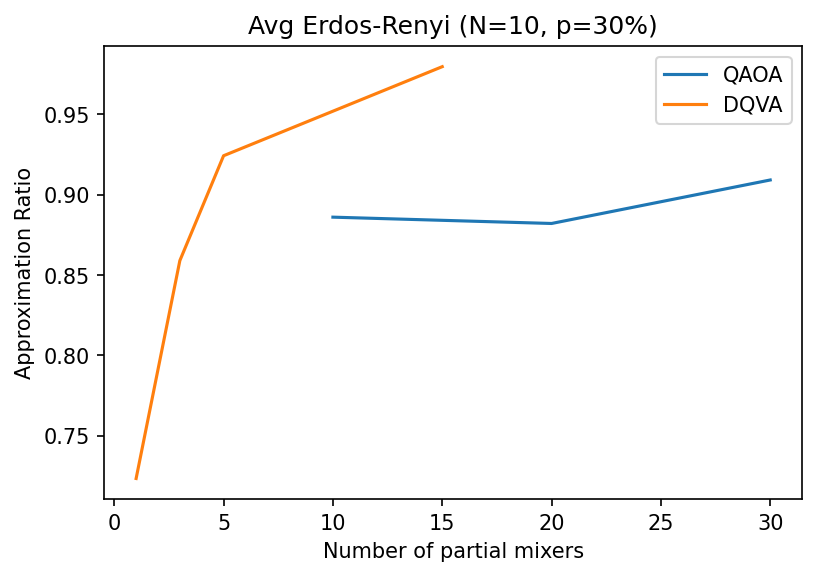

N8_p50_graphs
dqva lims: [2, 4, 6, 16]
qaoa pvals: [1, 2, 3]
{'Avg Erdos-Renyi (N=8, p=50%)': [(1, 0.7441666666666668), (3, 0.8519166666666668), (5, 0.9453333333333335), (15, 0.9910833333333332)]}
{'Avg Erdos-Renyi (N=8, p=50%)': [(8, 0.919666666666667), (16, 0.9233333333333333), (24, 0.93)]}
QAOA
[8, 16, 24]
[0.919666666666667, 0.9233333333333333, 0.93]
DQVA
[1, 3, 5, 15]
[0.7441666666666668, 0.8519166666666668, 0.9453333333333335, 0.9910833333333332]


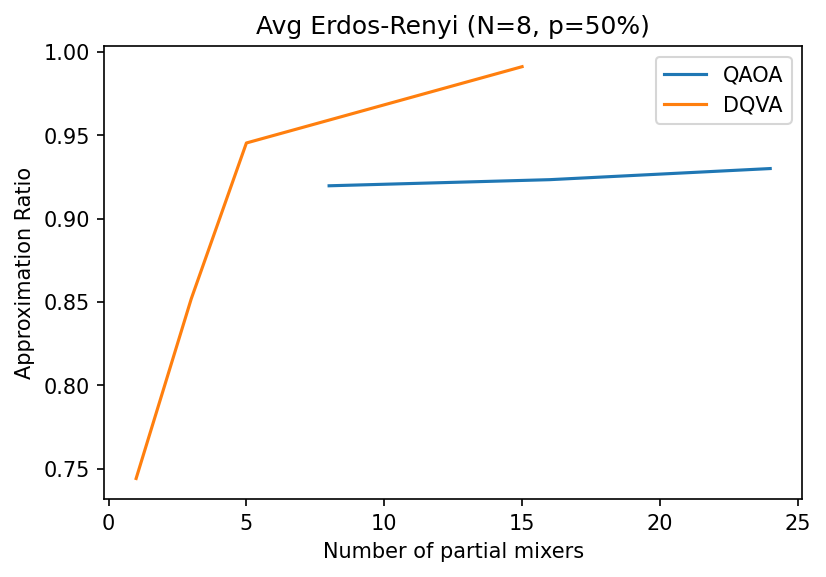

N6_p20_graphs
dqva lims: [2, 4, 6, 16]
qaoa pvals: [1, 2, 3]
{'Avg Erdos-Renyi (N=6, p=20%)': [(1, 0.8419166666666666), (3, 0.93475), (5, 0.9801666666666666), (14, 0.996)]}
{'Avg Erdos-Renyi (N=6, p=20%)': [(6, 0.9439999999999997), (12, 0.9623333333333334), (18, 0.9759999999999998)]}
QAOA
[6, 12, 18]
[0.9439999999999997, 0.9623333333333334, 0.9759999999999998]
DQVA
[1, 3, 5, 14]
[0.8419166666666666, 0.93475, 0.9801666666666666, 0.996]


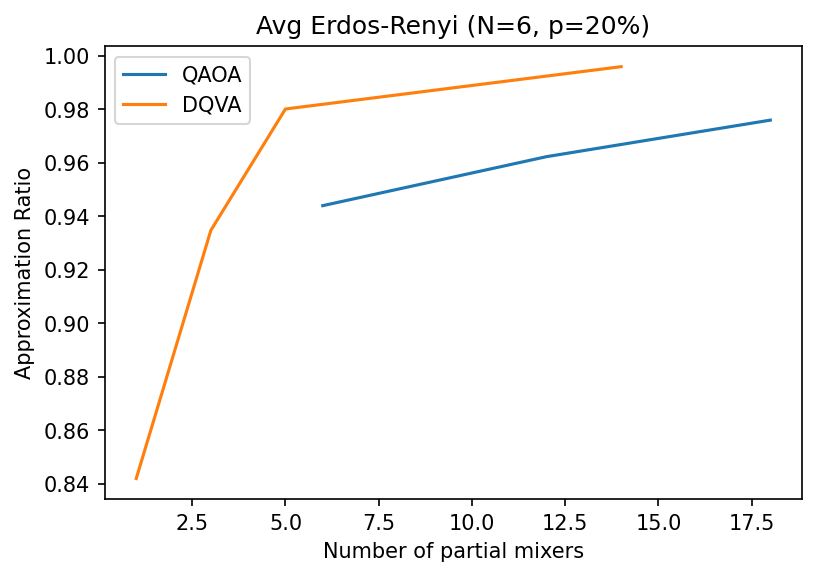

N10_p80_graphs
dqva lims: [16]
qaoa pvals: [1, 2, 3]
{'Avg Erdos-Renyi (N=10, p=80%)': [(15, 0.9613333333333334)]}
{'Avg Erdos-Renyi (N=10, p=80%)': [(10, 0.9046666666666667), (20, 0.9026666666666664), (30, 0.9199999999999998)]}
QAOA
[10, 20, 30]
[0.9046666666666667, 0.9026666666666664, 0.9199999999999998]
DQVA
[15]
[0.9613333333333334]


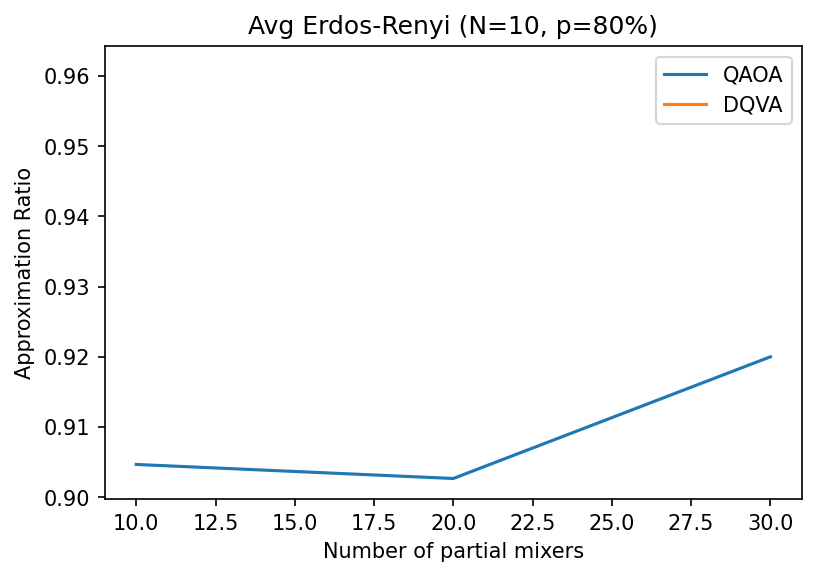

N16_p50_graphs
dqva lims: [2, 4, 6, 16]
qaoa pvals: [1, 2, 3]
{'Avg Erdos-Renyi (N=16, p=50%)': [(1, 0.58565), (3, 0.7358666666666666), (5, 0.8600666666666666), (15, 0.9249000000000003)]}
{'Avg Erdos-Renyi (N=16, p=50%)': [(16, 0.8395999999999999), (32, nan), (48, nan)]}
QAOA
[16, 32, 48]
[0.8395999999999999, nan, nan]
DQVA
[1, 3, 5, 15]
[0.58565, 0.7358666666666666, 0.8600666666666666, 0.9249000000000003]


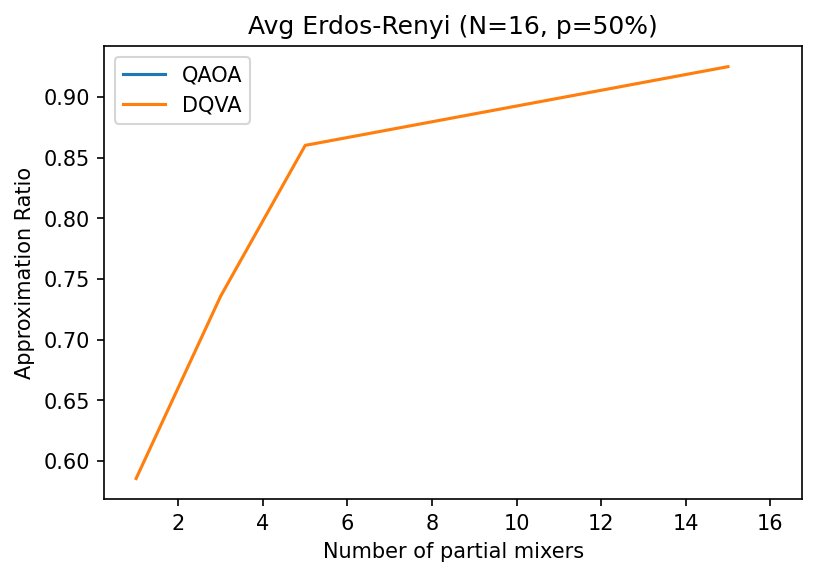

N12_p20_graphs
dqva lims: [2, 4, 6, 16]
qaoa pvals: [1, 2, 3]
{'Avg Erdos-Renyi (N=12, p=20%)': [(1, 0.7092154761904763), (3, 0.8480666666666665), (5, 0.9255857142857142), (15, 0.9821642857142858)]}
{'Avg Erdos-Renyi (N=12, p=20%)': [(12, 0.8822190476190477), (24, 0.8838904761904759), (36, 0.9064619047619044)]}
QAOA
[12, 24, 36]
[0.8822190476190477, 0.8838904761904759, 0.9064619047619044]
DQVA
[1, 3, 5, 15]
[0.7092154761904763, 0.8480666666666665, 0.9255857142857142, 0.9821642857142858]


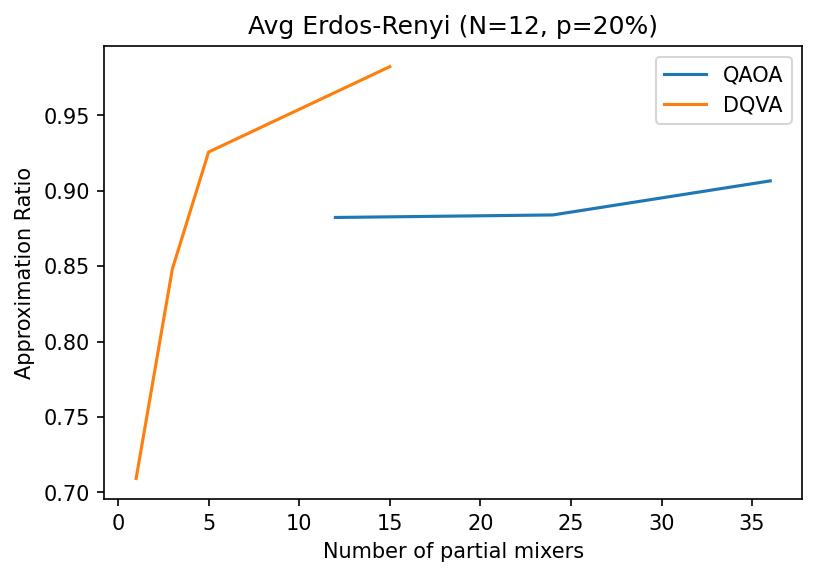

N6_p30_graphs
dqva lims: [2, 4, 6, 16]
qaoa pvals: [1, 2, 3]
{'Avg Erdos-Renyi (N=6, p=30%)': [(1, 0.8310833333333331), (3, 0.9235000000000001), (5, 0.9793333333333334), (14, 0.9976666666666667)]}
{'Avg Erdos-Renyi (N=6, p=30%)': [(6, 0.9469999999999997), (12, 0.9606666666666667), (18, 0.9706666666666665)]}
QAOA
[6, 12, 18]
[0.9469999999999997, 0.9606666666666667, 0.9706666666666665]
DQVA
[1, 3, 5, 14]
[0.8310833333333331, 0.9235000000000001, 0.9793333333333334, 0.9976666666666667]


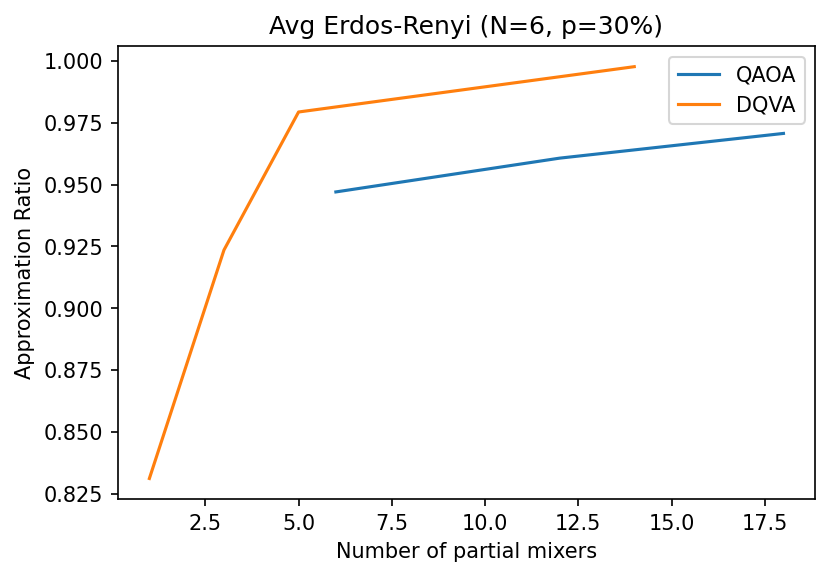

N12_p30_graphs
dqva lims: [2, 4, 6, 16]
qaoa pvals: [1, 2, 3]
{'Avg Erdos-Renyi (N=12, p=30%)': [(1, 0.6851166666666668), (3, 0.8275499999999998), (5, 0.9216166666666668), (15, 0.9726666666666666)]}
{'Avg Erdos-Renyi (N=12, p=30%)': [(12, 0.8655333333333333), (24, 0.8716666666666668), (36, 0.8908)]}
QAOA
[12, 24, 36]
[0.8655333333333333, 0.8716666666666668, 0.8908]
DQVA
[1, 3, 5, 15]
[0.6851166666666668, 0.8275499999999998, 0.9216166666666668, 0.9726666666666666]


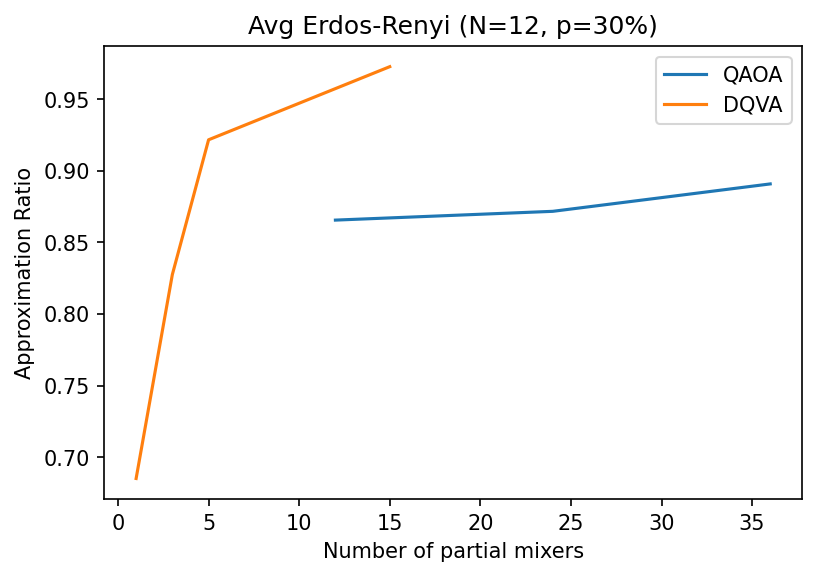

N14_p20_graphs
dqva lims: [2, 6, 16]
qaoa pvals: [1, 2, 3]
{'Avg Erdos-Renyi (N=14, p=20%)': [(1, 0.6670158730158731), (5, 0.909218253968254), (15, 0.970238095238095)]}
{'Avg Erdos-Renyi (N=14, p=20%)': [(14, 0.8681190476190476), (28, 0.8690873015873012), (42, 0.8737619047619049)]}
QAOA
[14, 28, 42]
[0.8681190476190476, 0.8690873015873012, 0.8737619047619049]
DQVA
[1, 5, 15]
[0.6670158730158731, 0.909218253968254, 0.970238095238095]


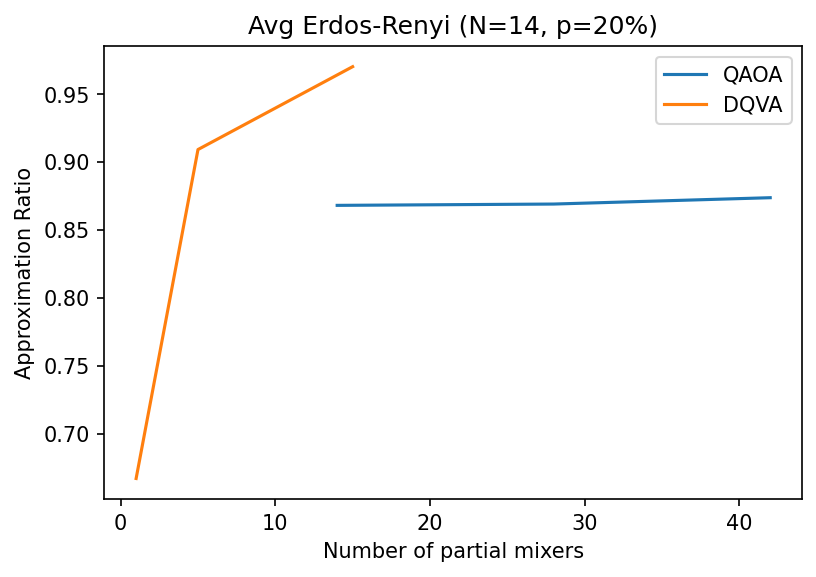

N16_p80_graphs
dqva lims: [16]
qaoa pvals: [1, 2, 3]
{'Avg Erdos-Renyi (N=16, p=80%)': [(15, 0.9094202898550726)]}
{'Avg Erdos-Renyi (N=16, p=80%)': [(16, 0.8363333333333332), (32, nan), (48, 0.8383333333333336)]}
QAOA
[16, 32, 48]
[0.8363333333333332, nan, 0.8383333333333336]
DQVA
[15]
[0.9094202898550726]


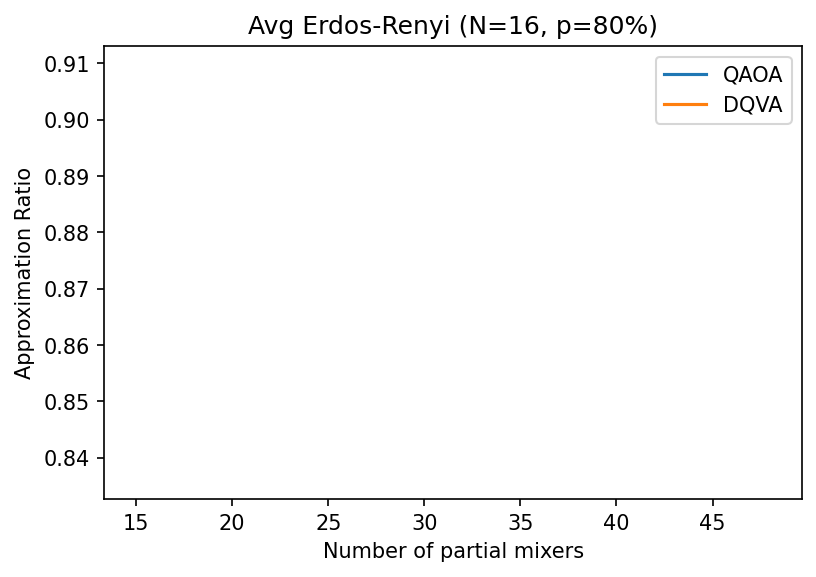

N10_p50_graphs
dqva lims: [2, 4, 6, 16]
qaoa pvals: [1, 2, 3]
{'Avg Erdos-Renyi (N=10, p=50%)': [(1, 0.6823666666666667), (3, 0.8247833333333334), (5, 0.9182833333333333), (15, 0.9696666666666668)]}
{'Avg Erdos-Renyi (N=10, p=50%)': [(10, 0.8866), (20, 0.8912666666666668), (30, 0.9132666666666666)]}
QAOA
[10, 20, 30]
[0.8866, 0.8912666666666668, 0.9132666666666666]
DQVA
[1, 3, 5, 15]
[0.6823666666666667, 0.8247833333333334, 0.9182833333333333, 0.9696666666666668]


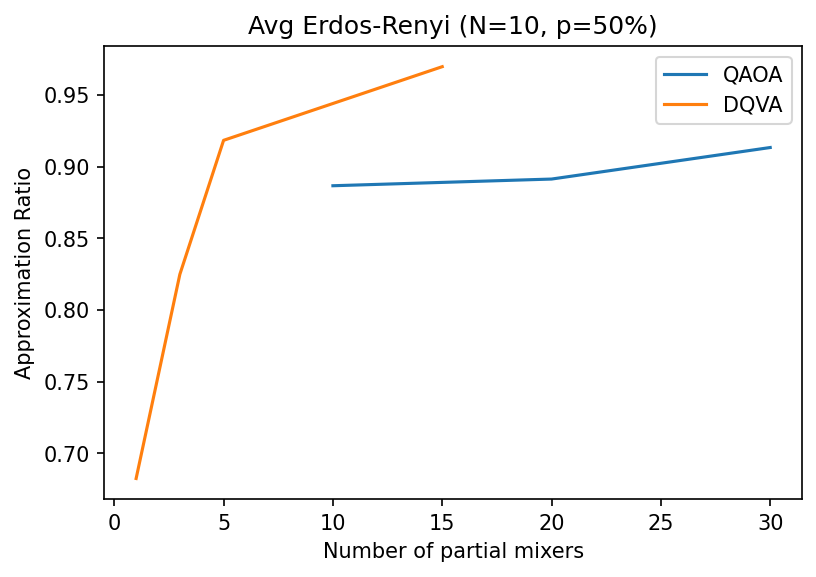

N8_p30_graphs
dqva lims: [2, 4, 6, 16]
qaoa pvals: [1, 2, 3]
{'Avg Erdos-Renyi (N=8, p=30%)': [(1, 0.7663333333333334), (3, 0.8755833333333336), (5, 0.9395333333333333), (15, 0.9839500000000001)]}
{'Avg Erdos-Renyi (N=8, p=30%)': [(8, 0.8988), (16, 0.8938000000000001), (24, 0.9250000000000003)]}
QAOA
[8, 16, 24]
[0.8988, 0.8938000000000001, 0.9250000000000003]
DQVA
[1, 3, 5, 15]
[0.7663333333333334, 0.8755833333333336, 0.9395333333333333, 0.9839500000000001]


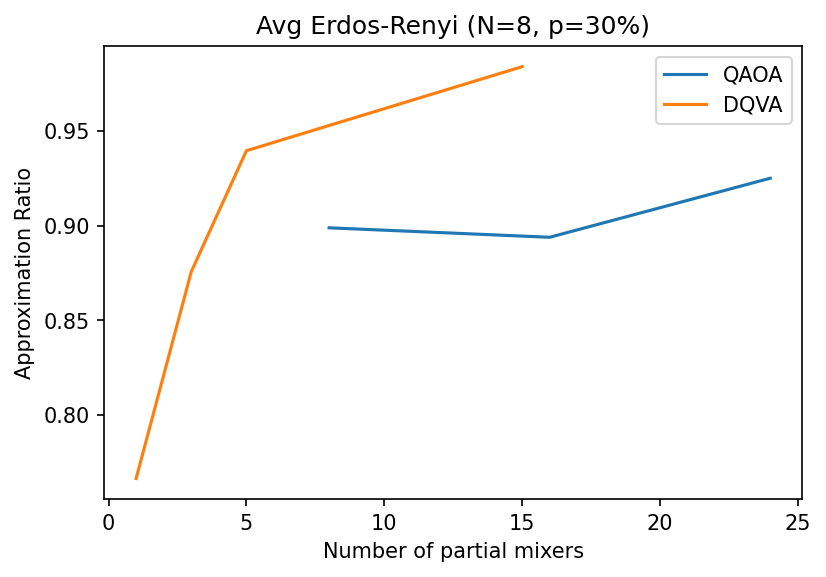

N8_p20_graphs
dqva lims: [2, 6, 16]
qaoa pvals: [1, 2, 3]
{'Avg Erdos-Renyi (N=8, p=20%)': [(1, 0.7970666666666668), (5, 0.9590666666666666), (15, 0.9928666666666668)]}
{'Avg Erdos-Renyi (N=8, p=20%)': [(8, 0.9057999999999999), (16, 0.9302000000000001), (24, 0.9560000000000001)]}
QAOA
[8, 16, 24]
[0.9057999999999999, 0.9302000000000001, 0.9560000000000001]
DQVA
[1, 5, 15]
[0.7970666666666668, 0.9590666666666666, 0.9928666666666668]


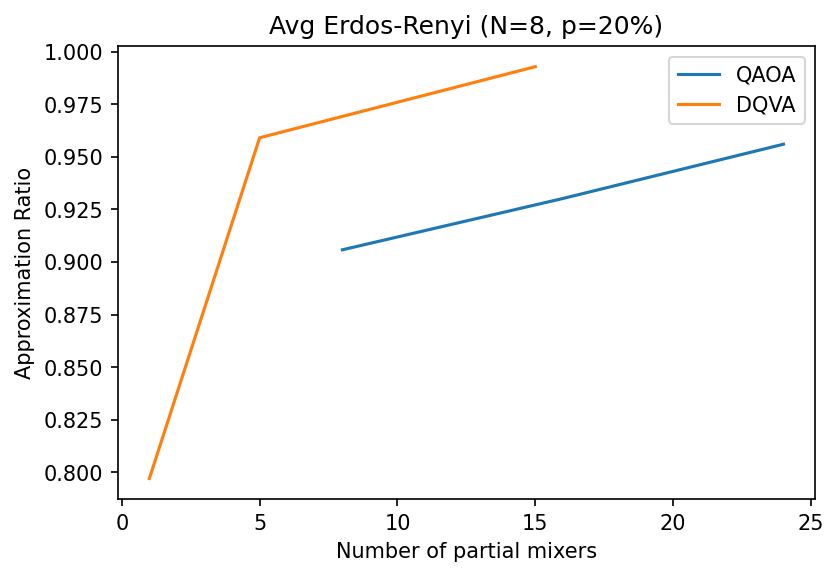

N14_p30_graphs
dqva lims: [2, 4, 6, 16]
qaoa pvals: [1, 2, 3]
{'Avg Erdos-Renyi (N=14, p=30%)': [(1, 0.6507523809523811), (3, 0.7833999999999999), (5, 0.8942714285714284), (15, 0.9680476190476192)]}
{'Avg Erdos-Renyi (N=14, p=30%)': [(14, 0.8507619047619046), (28, 0.8673904761904765), (42, 0.8742285714285712)]}
QAOA
[14, 28, 42]
[0.8507619047619046, 0.8673904761904765, 0.8742285714285712]
DQVA
[1, 3, 5, 15]
[0.6507523809523811, 0.7833999999999999, 0.8942714285714284, 0.9680476190476192]


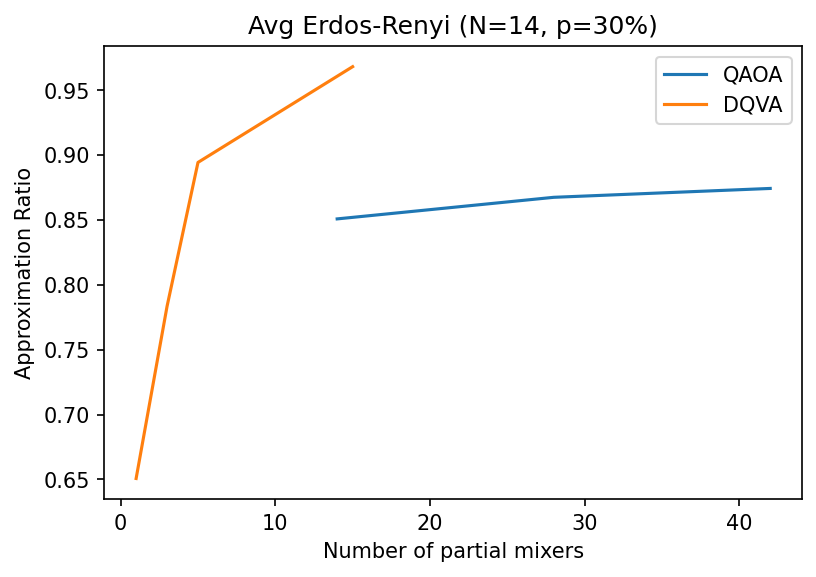

N14_p80_graphs
dqva lims: [16]


IndexError: list index out of range

In [169]:
graphs = glob.glob('benchmark_results/qaoa_P1_qasm/*')
graphs = [g.split('/')[-1] for g in graphs]
for graph in graphs:
    print(graph)
    name = 'Avg Erdos-Renyi (N={}, p={}%)'.format(graph.split('_')[0].strip('N'),
                                                 graph.split('_')[1].strip('p'))
    
    dqva_data, qaoa_data = load_data(graph)
    avg_dqva_data = {name:list(zip(dqva_data['x'], np.mean(np.array(dqva_data['y']), axis=0)))}
    avg_qaoa_data = {name:list(zip(qaoa_data['x'], np.mean(np.array(qaoa_data['y']), axis=0)))}
    print(avg_dqva_data)
    print(avg_qaoa_data)
    
    plot_comparison(avg_qaoa_data, avg_dqva_data)

## MISC testing

In [10]:
G = graph_from_file('benchmark_graphs/N12_p20_graphs/G2.txt')
nq = len(G.nodes())
init_state = '0'*nq
mo = list(range(nq))
param_lim = 2
P = 2
qaoa_output = dqva.solve_mis_qaoa(init_state, G, P=P, mixer_order=mo, sim='qasm', cutoff=1)
print('\nStart DQVA\n')
dqva_output = dqva.solve_mis_dqva(init_state, G, m=6, mixer_order=mo, sim='qasm', cutoff=1, param_lim=param_lim)

Start round 1.1, Initial state = 000000000000
	Num params = 4
	Current Mixer Order: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
	Optimal cost: -5.5076904296875
	Found new independent set: 100111101010, Hamming weight = 7
Start round 1.2, Initial state = 100111101010
	Num params = 4
	Current Mixer Order: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
	Optimal cost: -7.0
	None of the measured bitstrings had higher Hamming weight than: 100111101010
	RETURNING, best hamming weight: 7

Start DQVA

Start round 1.1, Initial state = 000000000000
	Num params = 2
	Current Mixer Order: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
	Optimal cost: -1.0
	Found new independent set: 000000000001, Hamming weight = 1
Start round 1.2, Initial state = 000000000001
	Num params = 2
	Current Mixer Order: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
	Optimal cost: -1.0
	None of the measured bitstrings had higher Hamming weight than: 000000000001
Start round 2.1, Initial state = 000000000001
	Num params = 2
	Current Mixer Order: [0, 5,

In [11]:
print(qaoa_output[0], qaoa_output[2], qaoa_output[3])
print(qaoa_output[1])
print()
print(dqva_output[0], dqva_output[2], dqva_output[3])
print(dqva_output[1])

100111101010 000000000000 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[ 2.52214283e+00 -2.02723472e-03 -9.60158258e-01  5.50223432e-02]

000000100101 000000100001 [0, 5, 2, 9, 10, 4, 11, 6, 3, 8, 7, 1]
[0.01232885 1.56283964]


In [12]:
qaoa_circ = qaoa.gen_qaoa(G, P, params=qaoa_output[1], init_state=qaoa_output[2],
                          mixer_order=qaoa_output[3], barriers=2)
qaoa_circ.measure_all()
#print(opt_circ.draw(fold=120))
qaoa_result = execute(qaoa_circ, backend=Aer.get_backend('qasm_simulator'), shots=8192).result()
qaoa_counts = qaoa_result.get_counts(qaoa_circ)

dqva_circ = dqv_ansatz.gen_dqva(G, P=1, params=dqva_output[1], init_state=dqva_output[2],
                                mixer_order=dqva_output[3], barriers=2, decompose_toffoli=1, param_lim=param_lim)
dqva_circ.measure_all()
dqva_result = execute(dqva_circ, backend=Aer.get_backend('qasm_simulator'), shots=8192).result()
dqva_counts = dqva_result.get_counts(dqva_circ)

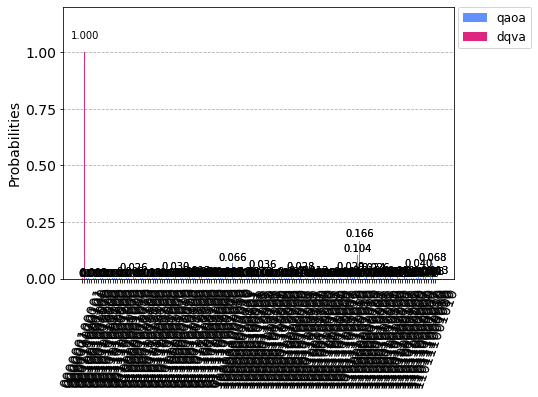

In [13]:
qiskit.visualization.plot_histogram([strip_ancillas(qaoa_counts, qaoa_circ), strip_ancillas(dqva_counts, dqva_circ)], legend=['qaoa', 'dqva'])